In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import random
import gc
import pickle
import math

from sklearn.decomposition import PCA

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
for directory in ['F19_All', 'S19_All']:
  base_path = os.path.join('data', directory, 'Train' if directory == 'F19_All' else '')
  grade_data = pd.read_csv(os.path.join(base_path, 'Data', 'LinkTables', 'Subject.csv'))
  for row in grade_data.itertuples():
    grades[row.SubjectID] = row._2 if directory == 'S19_All' else row._2 / 100
  main = pd.read_csv(os.path.join(base_path, 'Data', 'MainTable.csv'))
  total_non_compile += len(main['CodeStateID'].unique())
  for row in main[main['EventType'] == 'Run.Program'].itertuples():
    scores[row.CodeStateID] = row.Score
  main = main[(main['EventType'] == 'Compile') & (main['Compile.Result'] == 'Success')]
  main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
  data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data.head()

print(f'ALLL Programs: {total_non_compile}')

ALLL Programs: 161378


In [3]:
# Find the Code IDs for the submissions with the highest score for each student for each assignment
students = list(data['SubjectID'].unique())
assignments = data['Assignment'].unique()
best_score_data = {}
num_null_submissions = 0
for student in students:
  best_ids = [None] * len(assignments)
  s_filter = data[data['SubjectID'] == student]
  a_idx = 0
  for assignment in assignments:
    a_filter = s_filter[s_filter['Assignment'] == assignment].reset_index()
    if len(a_filter.index) > 0:
      best_ids[a_idx] = a_filter['CodeStateID'][np.argmax(a_filter['Score'])]
    else:
      num_null_submissions += 1
    a_idx += 1
  best_score_data[student] = best_ids
best_score_data[students[0]][0:5]

print(f"TOTAL Number of submissions: {len(data.index)}")
# Free some memory
del scores
del data
gc.collect()

print(f"Number of Students: {len(students)}")
print(f"Number of student-assignment pairs: {len(students) * len(assignments)}")
print(f"Number of assignment-student pairs with no submissions: {num_null_submissions}")

TOTAL Number of submissions: 96787
Number of Students: 774
Number of student-assignment pairs: 38700
Number of assignment-student pairs with no submissions: 4984


Train avg: 0.59 Test avg: 0.63
Train dev: 0.25 Test dev: 0.23
Train


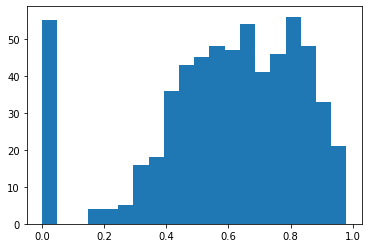

Number of students: 620
Missing Grades: 34
Test


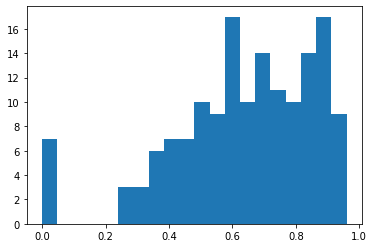

Number of students: 154
Missing Grades: 5


In [4]:
# Divide data into 80% training data, 20% testing data
random.seed(1)
num_students = len(students)
test_students = set(random.sample(students, int(num_students * 0.2)))
train_students = set([x for x in students if x not in test_students])

missing_test_grades = 0
missing_train_grades = 0

test_grades = []
for x in test_students:
  if x in grades:
    test_grades.append(grades[x])
  else:
    test_grades.append(0)
    missing_test_grades += 1

train_grades = []
for x in train_students:
  if x in grades:
    train_grades.append(grades[x])
  else:
    train_grades.append(0)
    missing_train_grades += 1


print(f'Train avg: {np.mean(train_grades):0.2f} Test avg: {np.mean(test_grades):0.2f}')
print(f'Train dev: {np.std(train_grades):0.2f} Test dev: {np.std(test_grades):0.2f}')

# test_ids = set([x in test_students for x in students])
# train_ids = set([x in train_students for x in students])
print('Train')
plt.hist(train_grades, bins=20)
plt.show()
print(f'Number of students: {len(train_students)}')
print(f'Missing Grades: {missing_train_grades}')

print('Test')
plt.hist(test_grades, bins=20)
plt.show()
print(f'Number of students: {len(test_students)}')
print(f'Missing Grades: {missing_test_grades}')

In [5]:
# code_states = {}
# for directory in ['F19_All', 'S19_All']:
#   base_path = os.path.join('data', directory, 'Train' if directory == 'F19_All' else '')
#   code_data = pd.read_csv(os.path.join(base_path, 'Data', 'CodeStates', 'CodeStates.csv'))
#   for row in code_data.itertuples():
#     code_states[row.CodeStateID] = row.Code

In [6]:
# random.seed(1)
# validation_set = set(random.sample(list(code_states.keys()), int(len(code_states) / 10)))
# for c_id in train_data['CodeStateID'].unique():
#   directory = 'Validate' if c_id in validation_set else 'Train' 
#   with open(os.path.join(directory, c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [7]:
# for c_id in test_data['CodeStateID'].unique():
#   with open(os.path.join('Test', c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [8]:
# Given a dataframe, a vector length, and a number of components,
# Divide all the vectors into a train and test set and transform them using PCA with the given number of components
def train_test_vectors(df, vector_length):
  train_X = []
  train_y = []
  test_X = []
  test_y = []
  vector_lookup = {}
  num_missing = 0
  total_train_sub = 0
  total_test_sub = 0
  for idx, row in df.iterrows():
    vector = np.array(row[0:vector_length])
    vector_lookup[row['CodeStateID']] = vector
  for student in students:
    all_assign = []
    num_present = 0
    for x in best_score_data[student]:
      if x in vector_lookup:
        all_assign.append(vector_lookup[x])
        num_present += 1
      else:
        num_missing += 1
        all_assign.append(np.zeros(vector_length))
    all_assign = np.concatenate(all_assign)
    if student in train_students:
      train_X.append(all_assign)
      train_y.append(grades[student] if student in grades else 0)
      total_train_sub += num_present
    elif student in test_students:
      test_X.append(all_assign)
      test_y.append(grades[student] if student in grades else 0)
      total_test_sub += num_present
#   pca = PCA(n_components=n_components, random_state=1)
#   train_X = pca.fit_transform(train_X)
#   test_X = pca.transform(test_X)
  print(f'Missing {num_missing} vectors')
  print(f'Train vectors: {total_train_sub}')
  print(f'Test vectors: {total_test_sub}')
  return train_X, train_y, test_X, test_y

In [9]:
def tune_model(name, model, parameters, n_iter):
  pipeline = Pipeline(steps=[('pca', PCA(random_state=1)), ('model', model)])
  if name in saved_models:
    pipeline.set_params(**saved_models[name])
  else:
    new_params = {'pca__n_components': parameters['n_components']}
    for key in parameters:
      if key != 'n_components':
        new_params['model__' + key] = parameters[key]
    cv = RandomizedSearchCV(pipeline, new_params, random_state=1, scoring='neg_mean_absolute_error', n_iter=n_iter, verbose=2)
    cv.fit(train_X, train_y)
    saved_models[name] = cv.best_params_
    with open('saved_models', 'wb') as f:
      pickle.dump(saved_models, f)
    pipeline.set_params(**cv.best_params_)
#   print("Variance captured: %0.3f" % np.sum(pipeline.steps[0].explained_variance_ratio_))
  return pipeline

In [10]:
with open('saved_models', 'rb') as f:
  saved_models = pickle.load(f)

In [11]:
models = [
  ('Linear', LinearRegression(), {'n_components': list(range(10, 300, 10))}),
  ('Ridge', Ridge(random_state=1), 
    {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
  ('Neural', MLPRegressor(random_state=1, max_iter=500, activation='logistic'), 
    {'n_components': list(range(10, 300, 10)),
     'hidden_layer_sizes': [(128, 64, 32, 16), (128, 64, 32), (128, 64), (64, 32, 16), (64, 32), (32, 16, 8), (32, 16), (16, 8)],
     'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
  ('Lasso', Lasso(random_state=1),
    {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]})
]

In [12]:
embedding_data = [
  ('code2vec', 384),
  ('deepwalk', 50),
  ('node2vec', 50),
  ('tf_idf', 50)
]

In [13]:
vectors = pd.read_csv('data/Vectors/deepwalk.csv')
train_X, train_y, test_X, test_y = train_test_vectors(vectors, 50)
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
pred_y = dummy.predict(test_X)
report_data = {'Model': ['Baseline (mean)'], 'Embedding': ['None'], 'MAE': [mean_absolute_error(test_y, pred_y)], 'RMSE': [math.sqrt(mean_squared_error(test_y, pred_y))]}

Missing 5081 vectors
Train vectors: 26863
Test vectors: 6756


In [14]:
for v_name, v_size in embedding_data:
  vectors = pd.read_csv('data/Vectors/' + v_name + '.csv')
  train_X, train_y, test_X, test_y = train_test_vectors(vectors, v_size)
  for m_name, model, params in models:
    model = tune_model(v_name + '_' + m_name, model, params, n_iter=50)
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    report_data['Model'].append(m_name + ' Regression')
    report_data['Embedding'].append(v_name)
    report_data['MAE'].append(mean_absolute_error(test_y, pred_y))
    report_data['RMSE'].append(math.sqrt(mean_squared_error(test_y, pred_y)))

Missing 4985 vectors
Train vectors: 26928
Test vectors: 6787
Missing 5081 vectors
Train vectors: 26863
Test vectors: 6756
Missing 5081 vectors
Train vectors: 26863
Test vectors: 6756
Missing 4984 vectors
Train vectors: 26928
Test vectors: 6788


In [15]:
pd.DataFrame(report_data)

,Model,Embedding,MAE,RMSE
0,Baseline (mean),None,0.185391,0.229134
1,Linear Regression,code2vec,0.163058,0.209201
2,Ridge Regression,code2vec,0.163058,0.209201
3,Neural Regression,code2vec,0.168861,0.214294
4,Lasso Regression,code2vec,0.159114,0.205285
5,Linear Regression,deepwalk,0.150040,0.194178
6,Ridge Regression,deepwalk,0.150040,0.194178
7,Neural Regression,deepwalk,0.143486,0.188590
8,Lasso Regression,deepwalk,0.150031,0.194052
9,Linear Regression,node2vec,0.149417,0.193812


In [16]:
pd.DataFrame(saved_models).transpose()

,pca__n_components,model__alpha,model__hidden_layer_sizes
code2vec_Linear,90.0,NaN,NaN
code2vec_Ridge,90.0,0.0001,NaN
code2vec_Neural,80,0.1,"(128, 64)"
code2vec_Lasso,150.0,0.01,NaN
deepwalk_Linear,40.0,NaN,NaN
deepwalk_Ridge,40.0,0.0001,NaN
deepwalk_Neural,100,0.01,"(128, 64)"
deepwalk_Lasso,40.0,0.0001,NaN
node2vec_Linear,40.0,NaN,NaN
node2vec_Ridge,40.0,0.0001,NaN


In [17]:
# import pickle
# with open('saved_models', 'wb') as f:
#   pickle.dump({}, f)